In [1]:
import numpy as np
import numpy.matlib
from matplotlib import pyplot as plt
import math
import time
from tensorflow.keras.datasets import mnist
import pandas as pd

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images_100 = train_images[:100] / 255.0  # Normalize and select
train_labels_100 = train_labels[:100]

test_images_100 = test_images[:100] / 255.0  # Normalize and select
test_labels_100 = test_labels[:100]

# Flatten the images
train_images_flat = train_images_100.reshape((100, -1)) 
test_images_flat = test_images_100.reshape((100, -1))


In [3]:
def getEuclideanDistance(single_point,array):
    nrows, ncols, nfeatures=array.shape[0],array.shape[1], array.shape[2]
    points=array.reshape((nrows*ncols,nfeatures))
                         
    dist = (points - single_point)**2
    dist = np.sum(dist, axis=1)
    dist = np.sqrt(dist)

    dist=dist.reshape((nrows,ncols))
    return dist

In [4]:

mu, sigma = 0, 0.1
A = np.random.normal(mu, sigma, 10)
#A.shape, A

In [5]:
nrows,ncols,nfeatures=3,3,3

#Generate coordinate system
x,y=np.meshgrid(range(ncols),range(nrows))

In [6]:

sgm0=2
sgmdecay=0.05
t=1
sgm = sgm0 * math.exp(-t*sgmdecay);

width = math.ceil(sgm*3)

dist=np.array([[2,1,3],[3,2,3],[4,4,4]])
bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape) 

g = np.exp(-((np.power(x - bmucol,2)) + (np.power(y - bmurow,2))) / (2*sgm*sgm));

fromrow = max(0,bmurow - width);
torow   = min(bmurow + width,nrows);
fromcol = max(0,bmucol - width);
tocol   = min(bmucol + width,ncols);

In [7]:
#G = np.dstack([g[fromrow:torow,fromcol:tocol]]*nfeatures);

gg = g[fromrow:torow,fromcol:tocol]
G = np.repeat(gg, nfeatures).reshape((gg.shape[0], gg.shape[1], nfeatures))

In [8]:
def SOM_images(som, dispRes, nrows, ncols):
    fig, ax=plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
        
    for k in range(nrows):
        for l in range (ncols):
            A=som[k,l,:].reshape((dispRes[0],dispRes[1]))
            ax[k,l].imshow(A,cmap="plasma")
            ax[k,l].set_yticks([])
            ax[k,l].set_xticks([])
    plt.show()

def SOM (dispRes, trainingData, ndim=20, nepochs=100, eta0=0.1, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=0):
    flag = 0
    nfeatures=trainingData.shape[1]
    ntrainingvectors=trainingData.shape[0]
    
    nrows = ndim
    ncols = ndim
    
    mu, sigma = 0, 0.1
    numpy.random.seed(int(time.time()))
    som = np.random.normal(mu, sigma, (nrows,ncols,nfeatures))

    if showMode >= 1:
        print("\nSOM features before training: \n")
        
        SOM_images(som, dispRes, nrows, ncols)  
    
    #Generate coordinate system
    x,y=np.meshgrid(range(ncols),range(nrows))
    
    for t in range (1,nepochs+1):
        #Compute the learning rate for the current epoch
        eta = eta0 * math.exp(-t*etadecay);
        
        #Compute the variance of the Gaussian (Neighbourhood) function for the ucrrent epoch
        sgm = sgm0 * math.exp(-t*sgmdecay);
        
        #Consider the width of the Gaussian function as 3 sigma
        width = math.ceil(sgm*3);
        
        for ntraining in range(ntrainingvectors):
            trainingVector = trainingData[ntraining,:];
            
            # Compute the Euclidean distance between the training vector and
            # each neuron in the SOM map
            dist = getEuclideanDistance(trainingVector, som);
       
            # Find 2D coordinates of the Best Matching Unit (bmu)
            bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape) ;
            
            
            #Generate a Gaussian function centered on the location of the bmu
            g = np.exp(-((np.power(x - bmucol,2)) + (np.power(y - bmurow,2))) / (2*sgm*sgm));

            #Determine the boundary of the local neighbourhood
            fromrow = max(0,bmurow - width);
            torow   = min(bmurow + width,nrows);
            fromcol = max(0,bmucol - width);
            tocol   = min(bmucol + width,ncols);

            
            #Get the neighbouring neurons and determine the size of the neighbourhood
            neighbourNeurons = som[fromrow:torow,fromcol:tocol,:];
            sz = neighbourNeurons.shape;
            
            #Transform the training vector and the Gaussian function into 
            # multi-dimensional to facilitate the computation of the neuron weights update
            T = np.matlib.repmat(trainingVector,sz[0]*sz[1],1).reshape((sz[0],sz[1],nfeatures));                   
            G = np.dstack([g[fromrow:torow,fromcol:tocol]]*nfeatures);

            # Update the weights of the neurons that are in the neighbourhood of the bmu
            neighbourNeurons = neighbourNeurons + eta * G * (T - neighbourNeurons);

            
            #Put the new weights of the BMU neighbouring neurons back to the
            #entire SOM map
            som[fromrow:torow,fromcol:tocol,:] = neighbourNeurons;
            if showMode >= 1:
                if ((t == (nepochs/2) ) and flag == 0):
                    print("\nSOM features AFTER 50 %: \n")
                    SOM_images(som, dispRes, nrows, ncols)
                    flag = 1

    if showMode >= 1:

        print("\nSOM features AFTER training: \n")
        SOM_images(som, dispRes, nrows, ncols)
        #fig, ax=plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
        
        #for k in range(nrows):
        #    for l in range (ncols):
        #        A=som[k,l,:].reshape((dispRes[0],dispRes[1]))
        #        ax[k,l].imshow(A,cmap="plasma")
        #        ax[k,l].set_yticks([])
        #    ax[k,l].set_xticks([])   
    return som
    

In [9]:
def parse_input_zoo_data(filename, header='infer'):

    input_data = pd.read_csv(filename, header=header)

    classes = input_data[17].tolist()
    labels = input_data[0].tolist()
    input_database = {
    0: input_data[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]].values
    }

    return input_database, labels, classes

In [10]:
input_filename = 'zoo.txt'
input_vector_database, labels, classes = parse_input_zoo_data(input_filename,None)



SOM features before training: 


SOM features AFTER 50 %: 


SOM features AFTER training: 



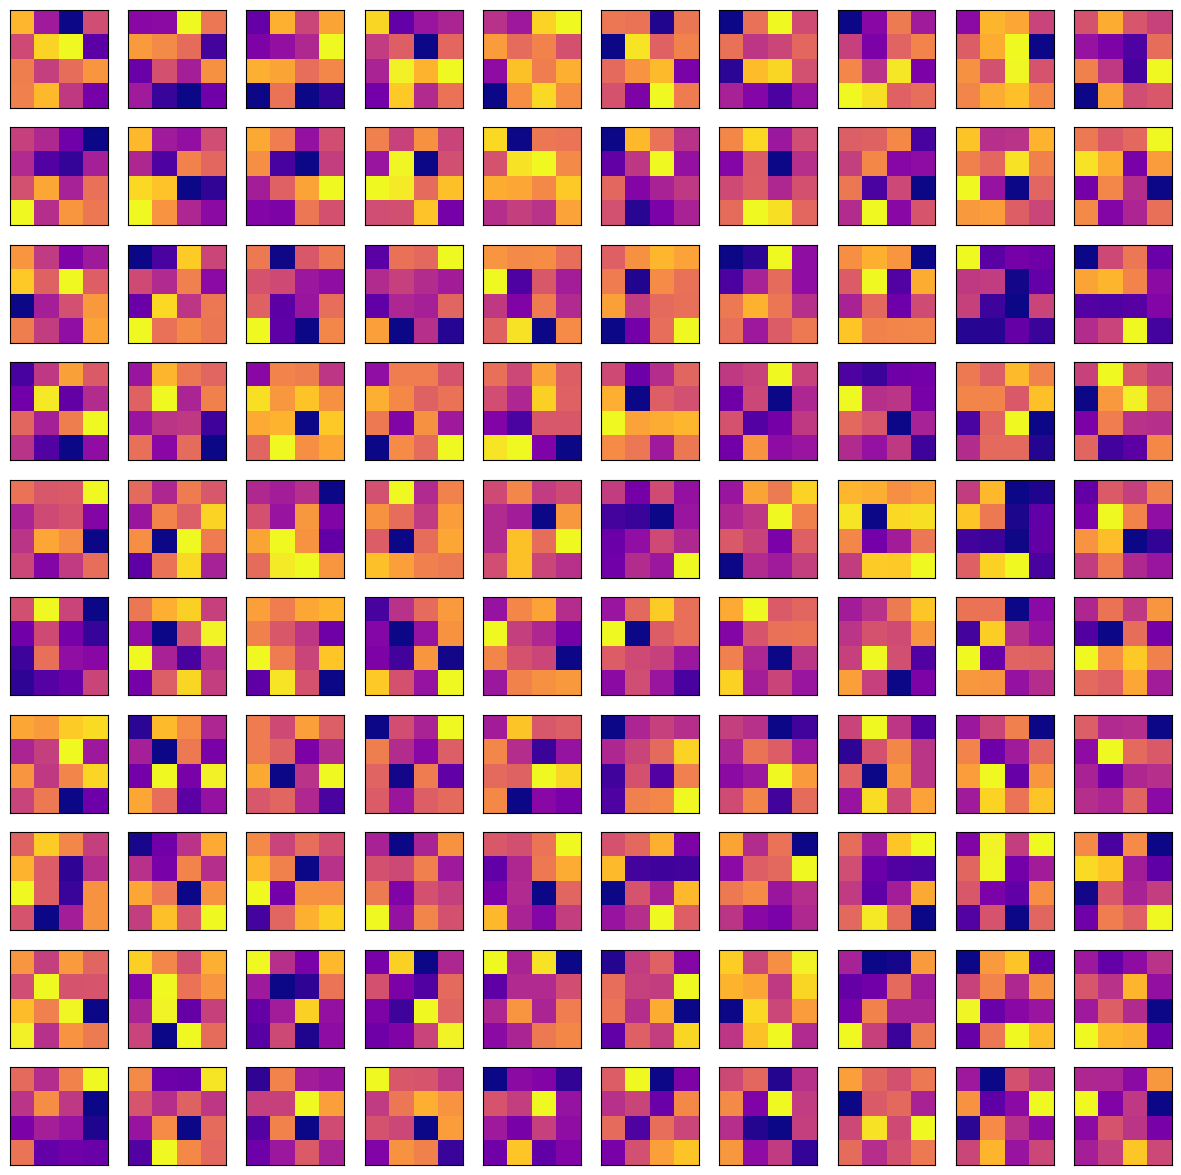

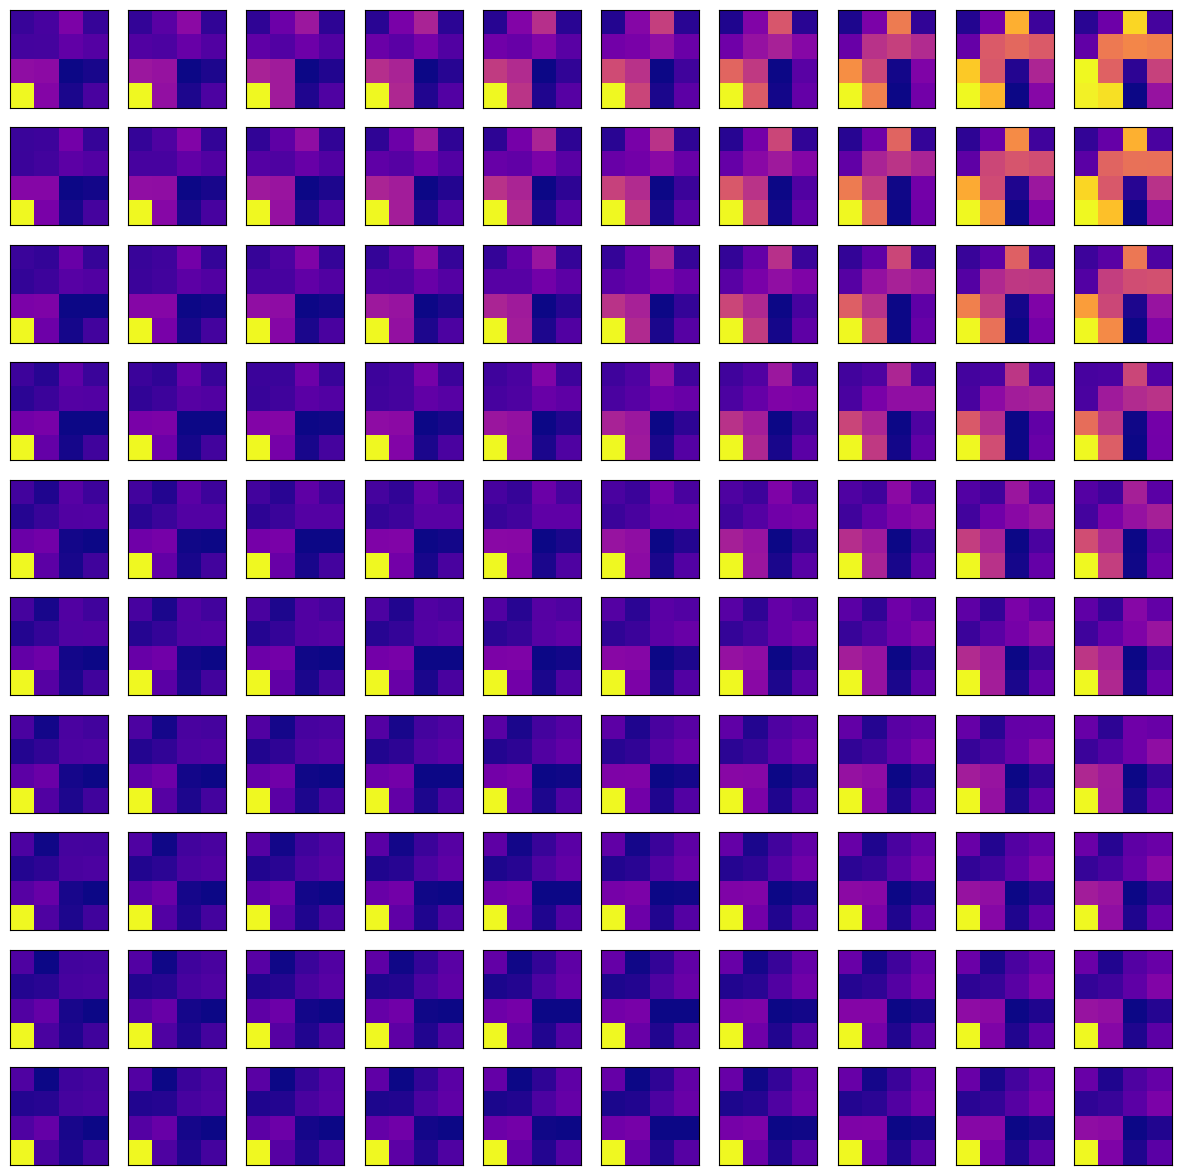

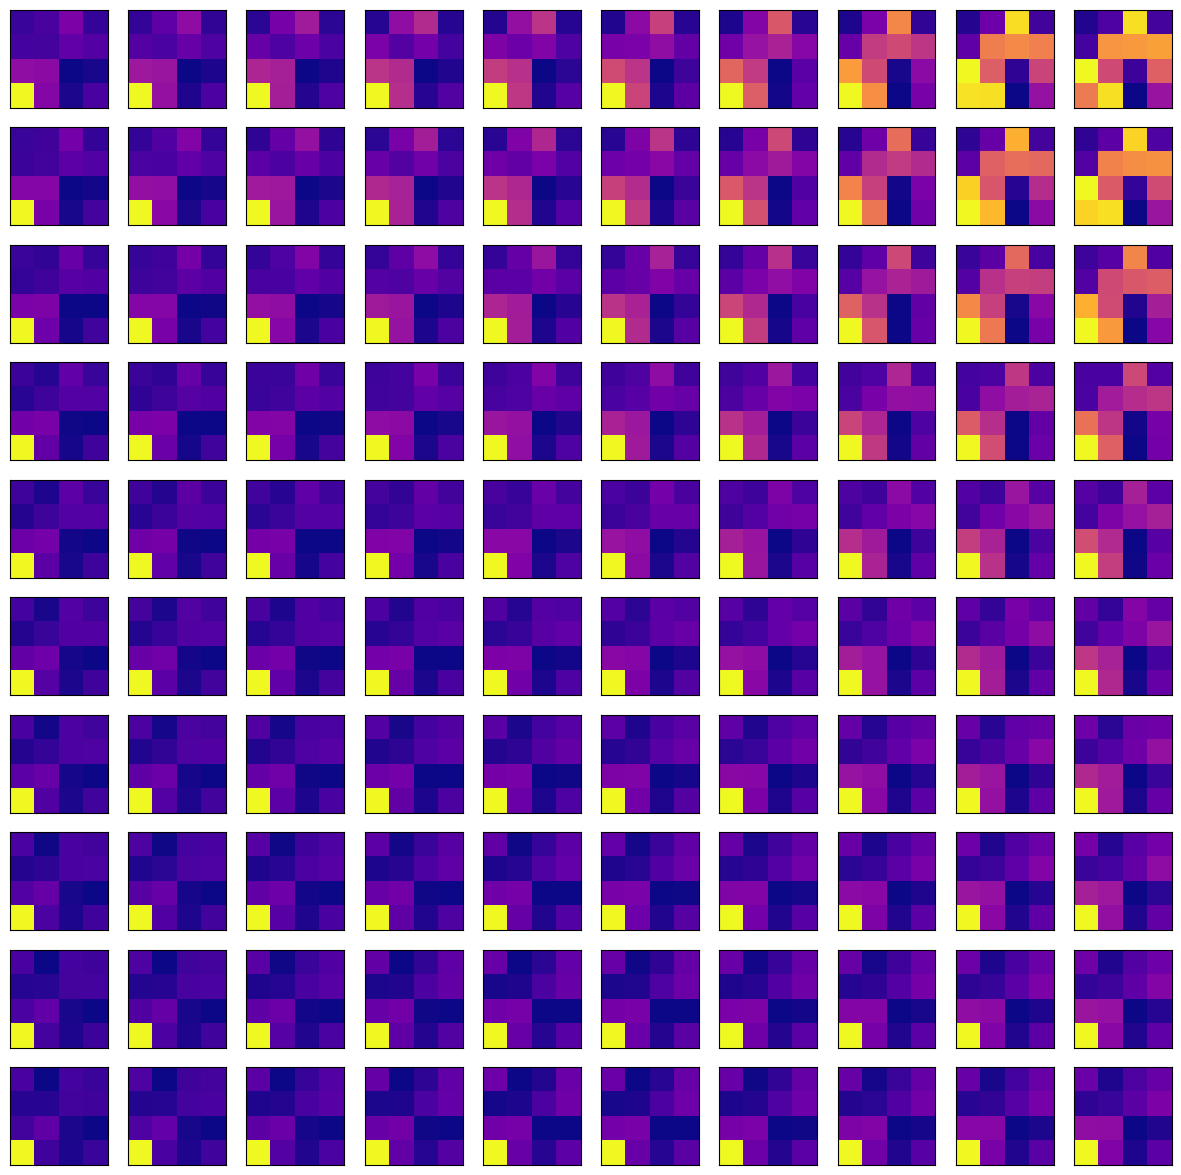

In [11]:
som_trained=SOM ([4,4],input_vector_database[0], ndim=10, nepochs=100, eta0=0.01, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=1)



SOM features before training: 


SOM features AFTER 50 %: 


SOM features AFTER training: 



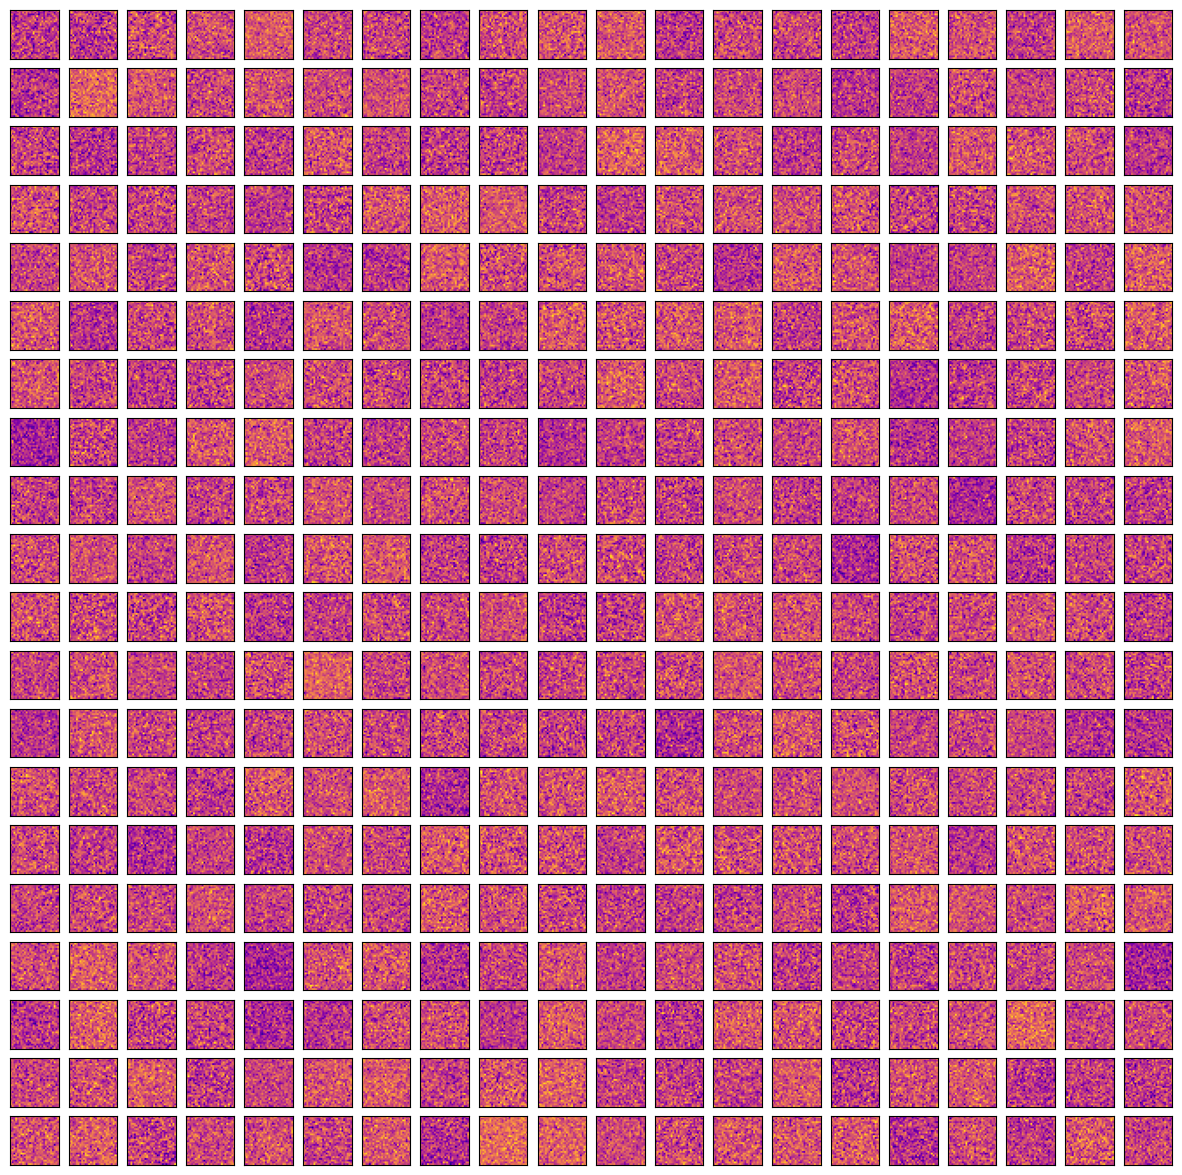

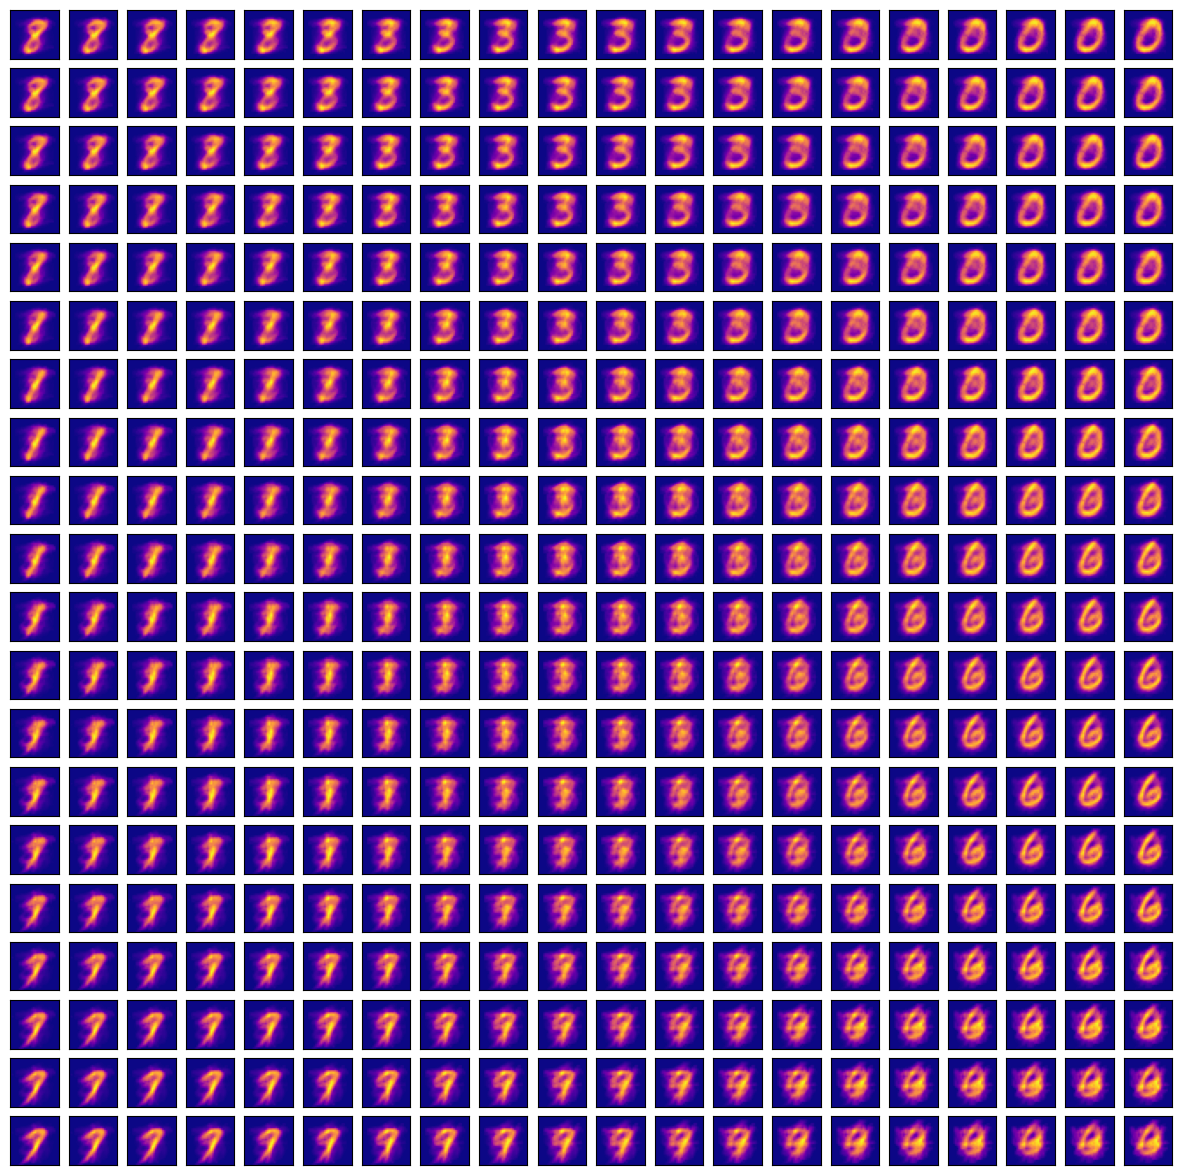

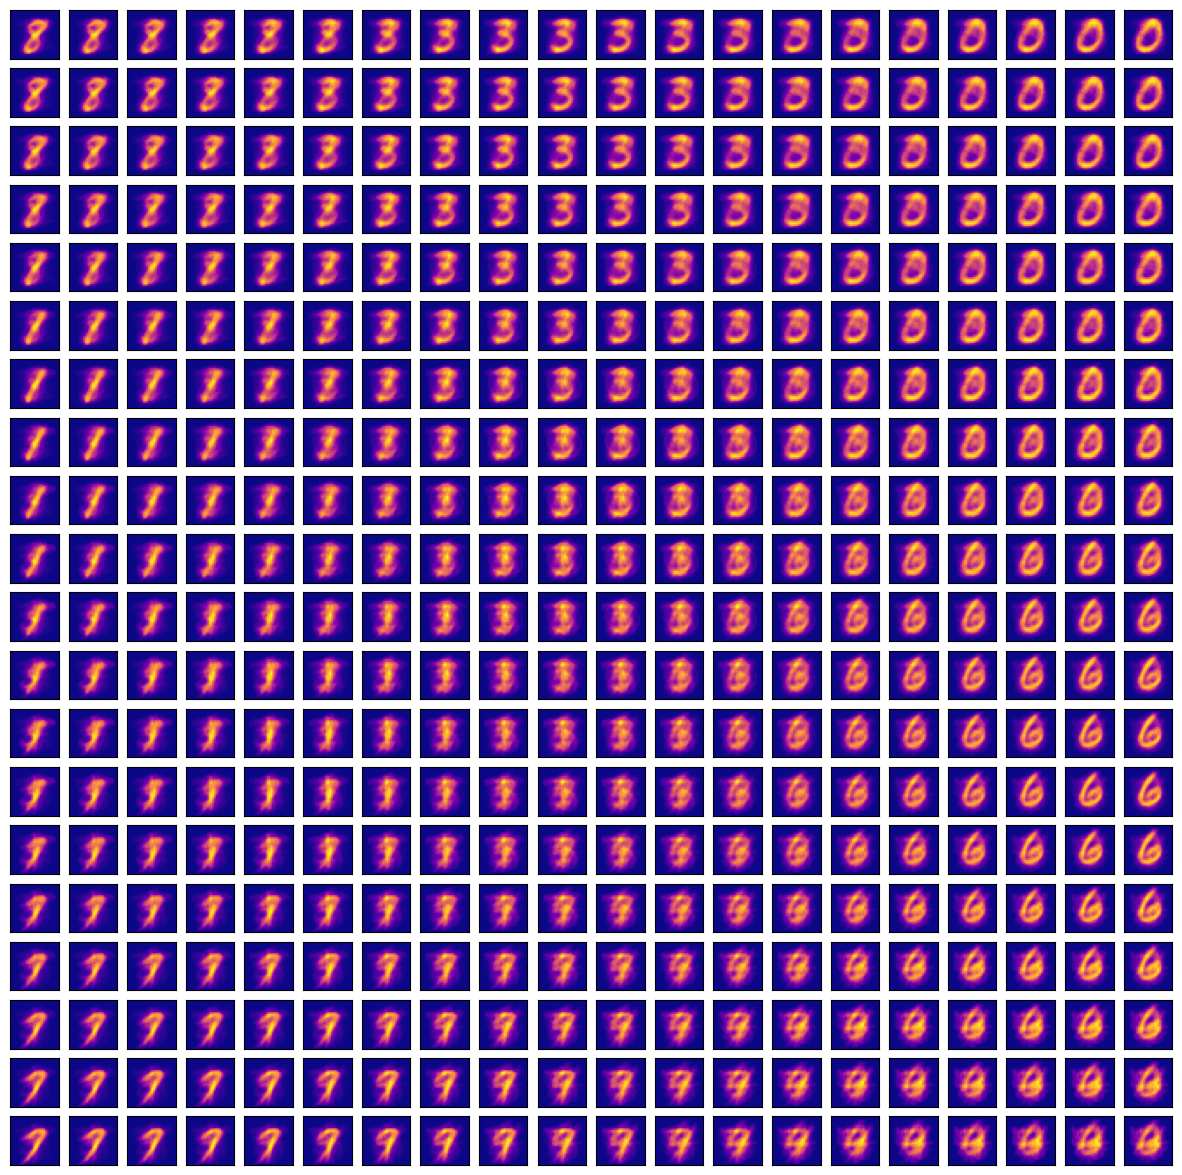

In [12]:
som_trained20=SOM ([28,28],train_images_flat, ndim=20, nepochs=100, eta0=0.01, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=1)
#som_trained40=SOM ([28,28],train_images_flat, ndim=40, nepochs=100, eta0=0.01, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=0)
#som_trained80=SOM ([28,28],train_images_flat, ndim=80, nepochs=100, eta0=0.01, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=0)

plt.show()

In [13]:
#verification of correctness on the training set:

def SOM_Test (trainingData, som_, classes, grid_, ConfusionMatrix, ndim=20):
    nfeatures=trainingData.shape[1]
    ntrainingvectors=trainingData.shape[0]
    

    nrows = ndim
    ncols = ndim
    
    nclasses=np.max(classes)

    som_cl=np.zeros((ndim,ndim,nclasses+1))
    
    
    for ntraining in range(ntrainingvectors):
        trainingVector = trainingData[ntraining,:];
        class_of_sample= classes[ntraining]    
        # Compute the Euclidean distance between the training vector and
        # each neuron in the SOM map
        dist = getEuclideanDistance(trainingVector, som_);
       
        # Find 2D coordinates of the Best Matching Unit (bmu)
        bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape) ;
        
        
        som_cl[bmurow, bmucol,class_of_sample]=som_cl[bmurow, bmucol,class_of_sample]+1
    
    
    
    for i in range (nrows):
        for j in range (ncols):
            grid_[i,j]=np.argmax(som_cl[i,j,:])

 
    for ntraining in range(ntrainingvectors):
        trainingVector = trainingData[ntraining,:];
        class_of_sample= classes[ntraining]    
        # Compute the Euclidean distance between the training vector and
        # each neuron in the SOM map
        dist = getEuclideanDistance(trainingVector, som_);
       
        # Find 2D coordinates of the Best Matching Unit (bmu)
        bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape) ;
        
        predicted=np.argmax(som_cl[bmurow, bmucol,:])
        ConfusionMatrix[class_of_sample-1, predicted-1]=ConfusionMatrix[class_of_sample-1, predicted-1]+1
        
    return grid_, ConfusionMatrix
    



In [14]:
def generateConfusionMatrix(digitImages,  classes, SOM, ndim=20):
    nrows = ndim
    ncols = ndim
    gridColor = np.zeros((nrows, ncols))
    nclasses = np.max(classes) # +1

    Confusion_Matrix = np.zeros((nclasses, nclasses))
    gridColor, Confusion_Matrix = SOM_Test(digitImages, SOM, classes, gridColor, Confusion_Matrix, ndim)
    
    plt.imshow(gridColor)
    plt.show()

    return Confusion_Matrix


In [15]:
def calulateAccuracy(Confusion_Matrix):
    true_positives = np.trace(Confusion_Matrix)

    total_samples = np.sum(Confusion_Matrix)

    accuracy = true_positives / total_samples

    print("Accuracy:", accuracy)

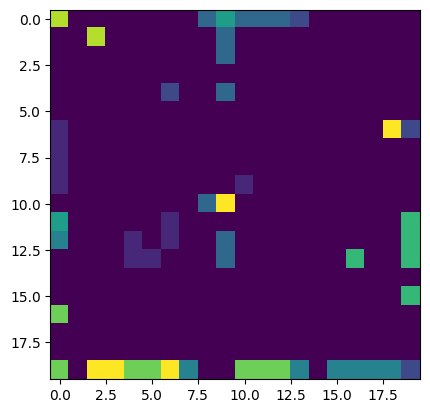

Accuracy: 0.9
[[14.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  6.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 11.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  9.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  1.  3.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 11.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 10.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  8.  0.]
 [ 0.  0.  0.  1.  0.  0.  5.  0. 18.]]


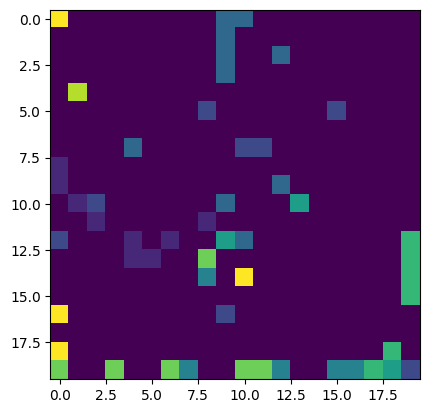

Accuracy: 0.81
[[14.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  8.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 11.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0. 11.  0.  1.  1.  0.  0.]
 [ 0.  2.  1.  0.  4.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  1.  8.  0.  0.  0.]
 [ 0.  0.  0.  3.  0.  0. 12.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  1.  0.  3.  0.  0.  3.  0. 12.]]


In [16]:

print("Training data: ")
ConfusionMatrix_training = generateConfusionMatrix(train_images_flat, train_labels, som_trained20, ndim=20)
calulateAccuracy(ConfusionMatrix_training)
print(ConfusionMatrix_training)

print("Testing data: ")
ConfusionMatrix_test = generateConfusionMatrix(test_images_flat, test_labels, som_trained20, ndim=20)
calulateAccuracy(ConfusionMatrix_test)
print(ConfusionMatrix_test)

#ConfusionMatrix_training = generateConfusionMatrix(train_images_flat, train_labels, som_trained40, ndim=40)
#print(calulateAccuracy(ConfusionMatrix_training))
#print(ConfusionMatrix_training)
#ConfusionMatrix_test = generateConfusionMatrix(test_images_flat, test_labels, som_trained40, ndim=40)
#rint(calulateAccuracy(ConfusionMatrix_test))
#print(ConfusionMatrix_test)

#ConfusionMatrix_training = generateConfusionMatrix(train_images_flat, train_labels, som_trained80, ndim=80)
#print(calulateAccuracy(ConfusionMatrix_training))
#print(ConfusionMatrix_training)
#ConfusionMatrix_test = generateConfusionMatrix(test_images_flat, test_labels, som_trained80, ndim=80)
#print(calulateAccuracy(ConfusionMatrix_test))
#print(ConfusionMatrix_test)


Training with eta0 = 0.005


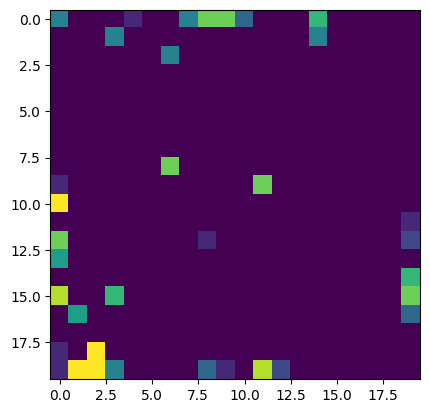

Accuracy: 0.56
None
[[11.  0.  0.  1.  0.  0.  0.  0.  2.]
 [ 2.  2.  0.  1.  0.  0.  0.  0.  1.]
 [ 4.  0.  3.  1.  0.  0.  0.  1.  2.]
 [ 3.  0.  0.  8.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  2.  0.  0.  0.  2.]
 [ 4.  0.  0.  0.  0.  3.  0.  0.  4.]
 [ 1.  0.  0.  0.  0.  0.  6.  0.  3.]
 [ 3.  1.  0.  0.  0.  0.  0.  3.  1.]
 [ 4.  0.  0.  1.  0.  0.  0.  1. 18.]]
Training with eta0 = 0.05


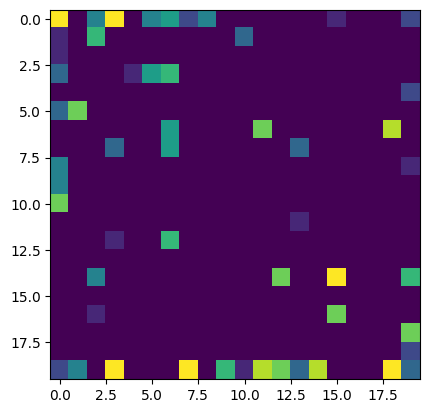

Accuracy: 0.71
None
[[10.  0.  0.  1.  0.  0.  0.  0.  3.]
 [ 0.  5.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  1.  7.  0.  0.  0.  0.  0.  2.]
 [ 0.  1.  0.  8.  0.  0.  0.  0.  2.]
 [ 0.  0.  0.  0.  4.  1.  0.  0.  0.]
 [ 1.  1.  1.  0.  0.  6.  0.  0.  2.]
 [ 1.  1.  1.  0.  0.  0.  7.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  1.  4.  2.]
 [ 1.  0.  1.  1.  1.  0.  0.  0. 20.]]
Training with eta0 = 0.1


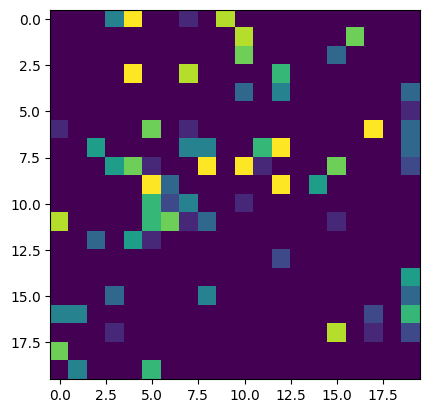

Accuracy: 0.85
None
[[13.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  5.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0. 10.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0. 10.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  5.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  1.  6.  0.  0.  2.]
 [ 0.  0.  1.  0.  0.  0.  7.  0.  2.]
 [ 2.  0.  0.  0.  0.  0.  0.  6.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0. 23.]]
Training with eta0 = 0.5


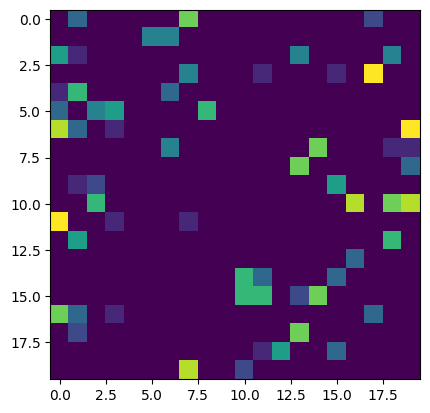

Accuracy: 0.79
None
[[13.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  5.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 11.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  1.  8.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  5.  0.  0.  0.  0.]
 [ 2.  0.  1.  0.  1.  7.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  7.  0.  2.]
 [ 1.  0.  0.  0.  0.  0.  0.  6.  1.]
 [ 3.  1.  1.  1.  0.  0.  0.  1. 17.]]
Training with eta0 = 0.8


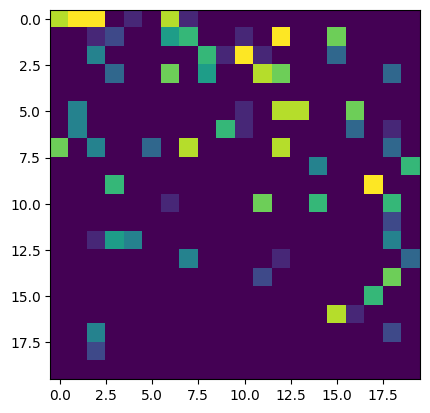

Accuracy: 0.82
None
[[14.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  5.  0.  0.  0.  0.  0.  0.  0.]
 [ 2.  0.  8.  0.  0.  0.  0.  0.  1.]
 [ 0.  2.  0.  9.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  3.  0.  0.  0.  1.]
 [ 1.  1.  0.  0.  1.  8.  0.  0.  0.]
 [ 0.  0.  0.  2.  0.  0.  7.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  8.  0.]
 [ 1.  1.  1.  0.  0.  1.  0.  0. 20.]]
Training with eta0 = 1


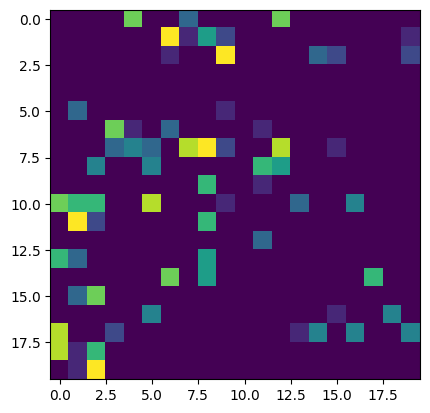

Accuracy: 0.81
None
[[13.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  6.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0. 10.  0.  0.  0.  0.  0.  0.]
 [ 0.  2.  0.  9.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  4.  0.  0.  0.  0.]
 [ 1.  0.  1.  1.  0.  8.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  6.  1.  2.]
 [ 1.  1.  0.  0.  0.  0.  0.  6.  0.]
 [ 1.  1.  1.  1.  0.  1.  0.  0. 19.]]


In [24]:
eta0s = [0.005, 0.05, 0.1, 0.5, 0.8, 1]
for eta0 in eta0s:
    print(f"Training with eta0 = {eta0}")
    som_trained=SOM ([28,28],train_images_flat, ndim=20, nepochs=100, eta0=eta0, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=0)
    ConfusionMatrix = generateConfusionMatrix(test_images_flat, train_labels, som_trained, ndim=20)
    print(calulateAccuracy(ConfusionMatrix))
    print(ConfusionMatrix)

Training with eta0 = 0.005


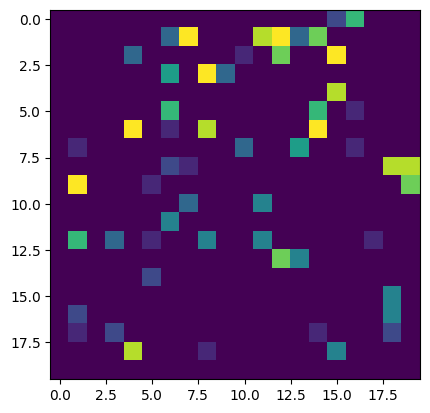

Accuracy: 0.74
None
[[13.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  6.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  8.  0.  0.  0.  0.  0.  2.]
 [ 0.  0.  1.  8.  0.  0.  1.  0.  1.]
 [ 1.  1.  0.  0.  3.  0.  0.  0.  0.]
 [ 1.  2.  2.  0.  0.  4.  0.  0.  2.]
 [ 1.  0.  1.  0.  0.  1.  5.  0.  2.]
 [ 1.  0.  0.  0.  0.  0.  1.  6.  0.]
 [ 1.  1.  1.  0.  0.  0.  0.  0. 21.]]
Training with eta0 = 0.05


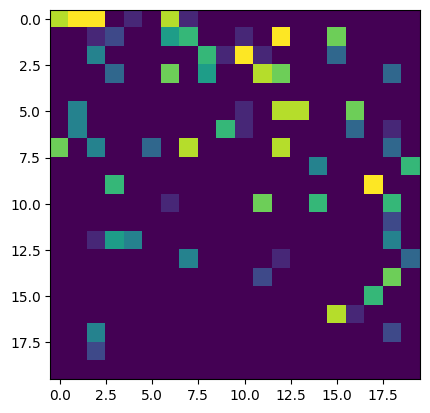

Accuracy: 0.82
None
[[14.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  5.  0.  0.  0.  0.  0.  0.  0.]
 [ 2.  0.  8.  0.  0.  0.  0.  0.  1.]
 [ 0.  2.  0.  9.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  3.  0.  0.  0.  1.]
 [ 1.  1.  0.  0.  1.  8.  0.  0.  0.]
 [ 0.  0.  0.  2.  0.  0.  7.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  8.  0.]
 [ 1.  1.  1.  0.  0.  1.  0.  0. 20.]]
Training with eta0 = 0.1


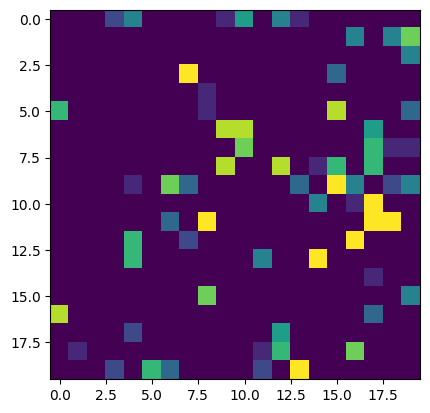

Accuracy: 0.8
None
[[12.  0.  0.  0.  0.  0.  0.  0.  2.]
 [ 0.  6.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  7.  0.  0.  0.  0.  0.  4.]
 [ 0.  1.  0. 10.  0.  0.  0.  0.  0.]
 [ 2.  0.  0.  0.  3.  0.  0.  0.  0.]
 [ 1.  1.  0.  1.  0.  8.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  1.  5.  0.  2.]
 [ 0.  0.  0.  0.  0.  1.  0.  6.  1.]
 [ 0.  0.  0.  1.  0.  0.  0.  0. 23.]]
Training with eta0 = 0.5


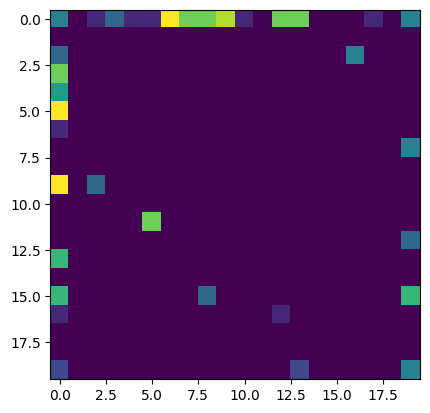

Accuracy: 0.55
None
[[ 9.  1.  0.  4.  0.  0.  0.  0.  0.]
 [ 0.  3.  0.  3.  0.  0.  0.  0.  0.]
 [ 0.  1.  5.  4.  0.  0.  0.  0.  1.]
 [ 0.  0.  0. 10.  0.  0.  0.  0.  1.]
 [ 2.  0.  0.  0.  1.  0.  0.  1.  1.]
 [ 2.  1.  0.  5.  0.  3.  0.  0.  0.]
 [ 0.  1.  1.  2.  0.  0.  6.  0.  0.]
 [ 1.  1.  1.  2.  0.  0.  1.  2.  0.]
 [ 1.  0.  0.  6.  0.  0.  0.  1. 16.]]
Training with eta0 = 0.8


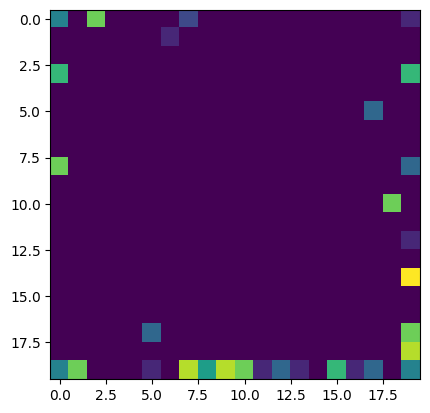

Accuracy: 0.5
None
[[ 8.  0.  0.  6.  0.  0.  0.  0.  0.]
 [ 2.  1.  0.  3.  0.  0.  0.  0.  0.]
 [ 1.  0.  5.  5.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 11.  0.  0.  0.  0.  0.]
 [ 1.  0.  1.  1.  1.  0.  0.  0.  1.]
 [ 3.  0.  0.  5.  0.  3.  0.  0.  0.]
 [ 1.  0.  0.  2.  0.  0.  7.  0.  0.]
 [ 2.  0.  0.  2.  0.  0.  0.  4.  0.]
 [ 3.  0.  0. 10.  1.  0.  0.  0. 10.]]


In [27]:
# best eta0 was 0.1
etadecays = [0.005, 0.05, 0.1, 0.5, 0.8]
for etadecay in etadecays: 
    print(f"Training with eta0 = {etadecay}")
    som_trained=SOM ([28,28],train_images_flat, ndim=20, nepochs=100, eta0=0.8, etadecay=etadecay, sgm0=20, sgmdecay=0.05, showMode=0)
    ConfusionMatrix = generateConfusionMatrix(test_images_flat, train_labels, som_trained, ndim=20)
    print(calulateAccuracy(ConfusionMatrix))
    print(ConfusionMatrix)


## Question

6. 
Decreased learning rate results in decreased accuracy, and increased learning rate results in increased accuracy but only up to a point. 

7/8. 
When increasing the exponential decay for the best learning rate, the accuracy only became worse. If we increased or deceased the exponentail decay the accuracy only fell. 

Best learning rate = 0.8
best exponential decay = 0.05
9. 
Nuerons are the most common cell in the brain, which processes and transmits signals. The artifical nurons in the SOM learns to represent different patterns in the data to create images of numbers. 


In [19]:
#Confusion_Matrix, input_vector_database[0].shape, np.sum(Confusion_Matrix)